In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf
from tensorflow.keras import backend as keras_backend
import numpy as np

gpu_on = True

if gpu_on :
    gpu_devices = tf.config.experimental.list_physical_devices("GPU")
    for device in gpu_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    gpu_devices = tf.config.experimental.list_physical_devices("CPU")

print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from src.data_loader.cycle_gan import CycleGanDataloader
from tensorflow.keras.applications.inception_v3 import preprocess_input
from glob import glob

task = "cycle_gan"
data_set_name = "HE_IHC_dataset"
batch_size = 4
on_memory = True
argumentation_proba = 0.8
target_size = (512, 512)
interpolation = "bilinear"
dtype="float32"

train_image_path_list = glob(f"./datasets/{task}/{data_set_name}/HE/train/*/*")
train_target_image_path_list = glob(f"./datasets/{task}/{data_set_name}/IHC/train/*/*")
test_image_path_list = glob(f"./datasets/{task}/{data_set_name}/HE/test/*/*")
test_target_image_path_list = glob(f"./datasets/{task}/{data_set_name}/IHC/test/*/*")

train_data_loader = CycleGanDataloader(image_path_list=train_image_path_list,
                                       target_image_path_list=train_target_image_path_list,
                                       batch_size=batch_size,
                                       on_memory=on_memory,
                                       argumentation_proba=argumentation_proba,
                                       preprocess_input=preprocess_input,
                                       target_size=target_size,
                                       interpolation=interpolation,
                                       shuffle=True,
                                       dtype=dtype
)
test_data_loader = CycleGanDataloader(image_path_list=test_image_path_list,
                                      target_image_path_list=test_target_image_path_list,
                                       batch_size=1,
                                       on_memory=False,
                                       argumentation_proba=0,
                                       preprocess_input=preprocess_input,
                                       target_size=target_size,
                                       interpolation=interpolation,                                       
                                       shuffle=False,
                                       dtype=dtype
)

100%|██████████| 11000/11000 [01:49<00:00, 100.73it/s]


Source data num 11000, Target data num: 11000
Source data num 3000, Target data num: 3000


In [3]:
from copy import deepcopy

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.activations import sigmoid
from tensorflow.image import ssim

import segmentation_models as sm
sm.set_framework ('tf.keras')

from src.util.custom_loss import dice_score
from src.util.loss_cycle_gan import get_channel_weighted_dice_loss, get_channel_weighted_mse_loss
from src.model.cycle_gan import CycleGan
from src.model.inceptionv3_tf_2_2 import InceptionV3

BACKBONE="inceptionv3"
DROPOUT_RATIO = 0.5

optimizer = Nadam(5e-5, beta_1=0.5, clipnorm=1)
input_image_shape = (*target_size, 3)
output_image_shape = (*target_size, 3)

generator_G = sm.Unet(backbone_name=BACKBONE, 
                      input_shape=(None, None, 3), 
                      classes=3, activation="tanh")
generator_F = sm.Unet(backbone_name=BACKBONE, 
                      input_shape=(None, None, 3), 
                      classes=3, activation="tanh")

base_discriminator_X = InceptionV3(
    include_top=False,
    weights=None,
    input_tensor=None,
    input_shape=(None,None,3),
    classes=None,
    normliazation="LayerNormalization",
    pooling=None,
    classifier_activation=None
)

# (Batch_Size,?)
# discriminator_X_output = GlobalAveragePooling2D()(base_discriminator_X.output)
# discriminator_X_output = Dropout(DROPOUT_RATIO)(discriminator_X_output)
# # let's add a fully-connected layer
# # (Batch_Size,1)
# discriminator_X_output = Dense(1024, activation='relu')(discriminator_X_output)
# # (Batch_Size,1024)
# discriminator_X_output = Dropout(DROPOUT_RATIO)(discriminator_X_output)
# x_predictions = Dense(1)(discriminator_X_output)

discriminator_X = Model(base_discriminator_X.input, base_discriminator_X.output)

base_discriminator_Y = InceptionV3(
    include_top=False,
    weights=None,
    input_tensor=None,
    input_shape=(None,None,3),
    classes=None,
    normliazation="LayerNormalization",
    pooling=None,
    classifier_activation=None
)
# (Batch_Size,?)
# discriminator_Y_output = GlobalAveragePooling2D()(base_discriminator_Y.output)
# discriminator_Y_output = Dropout(DROPOUT_RATIO)(discriminator_Y_output)
# # let's add a fully-connected layer
# # (Batch_Size,1)
# discriminator_Y_output = Dense(1024, activation='relu')(discriminator_Y_output)
# # (Batch_Size,1024)
# discriminator_Y_output = Dropout(DROPOUT_RATIO)(discriminator_Y_output)
# y_predictions = Dense(1)(discriminator_Y_output)

discriminator_Y = Model(base_discriminator_Y.input, base_discriminator_Y.output)

cycle_gan_model = CycleGan(
    generator_G=generator_G, 
    generator_F=generator_F, 
    discriminator_X=discriminator_X, 
    discriminator_Y=discriminator_Y
)

cycle_gan_model.compile(
    generator_G_optimizer=optimizer,
    generator_F_optimizer=optimizer,
    discriminator_X_optimizer=optimizer,
    discriminator_Y_optimizer=optimizer,
    image_loss_fn=get_channel_weighted_mse_loss
)


Segmentation Models: using `tf.keras` framework.


In [4]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.preprocessing import image
from matplotlib import pyplot as plt

class GANMonitor(Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, data_loader, save_image_path, num_img=4):
        self.data_loader = data_loader
        self.num_img = num_img
        self.save_image_path = save_image_path
        
        os.makedirs(save_image_path, exist_ok=True)
        
    def on_epoch_end(self, epoch, logs=None):
        
        len_data_loader = len(self.data_loader)
        random_index = range(len_data_loader)
        random_index = np.random.permutation(random_index)[:self.num_img]
        
        _, ax = plt.subplots(self.num_img, 4, figsize=(12, 12))
        for current_index, image_index in enumerate(random_index):
            image_array, target_image_array = self.data_loader[image_index]
            iamge_array_name = self.data_loader.data_getter.target_image_path_dict[image_index]
            prediction = self.model.generator_G(image_array).numpy()[0]
            reverse_prediction = self.model.generator_F(target_image_array).numpy()[0]
            
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            reverse_prediction = (reverse_prediction * 127.5 + 127.5).astype(np.uint8)
            
            image_array = (image_array[0] * 127.5 + 127.5).astype(np.uint8)
            target_image_array = (target_image_array[0] * 127.5 + 127.5).astype(np.uint8)
            
            ax[current_index, 0].imshow(image_array)
            ax[current_index, 1].imshow(prediction)
            ax[current_index, 0].set_title("Input image_x")
            ax[current_index, 1].set_title("Translated image_y")
#             ax[current_index, 0].axis("off")
#             ax[current_index, 1].axis("off")

            ax[current_index, 2].imshow(target_image_array)
            ax[current_index, 3].imshow(reverse_prediction)
            ax[current_index, 2].set_title("Input image_y")
            ax[current_index, 3].set_title("Translated image_x")
#             ax[current_index, 0].axis("off")
#             ax[current_index, 1].axis("off")

            prediction = image.array_to_img(prediction)
            reverse_prediction = image.array_to_img(reverse_prediction)
        plt.savefig(f"{self.save_image_path}/generated_image_{epoch+1}")
        plt.show()
        plt.close()
        
class ModelCheckpointWithWeight(ModelCheckpoint):
    """A callback to generate and save images after each epoch"""

    def __init__(self, *args, **kwargs):
        super(ModelCheckpointWithWeight, self).__init__(*args, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        super(ModelCheckpointWithWeight, self).on_epoch_end(epoch, logs=logs)
        save_folder = self.filepath.format(epoch=epoch+1)
        
        self.model.generator_G.save_weights(f"{save_folder}/generator_G.hdf5")
        self.model.generator_F.save_weights(f"{save_folder}/generator_F.hdf5")
        self.model.discriminator_X.save_weights(f"{save_folder}/discriminator_X.hdf5")
        self.model.discriminator_Y.save_weights(f"{save_folder}/discriminator_Y.hdf5")

class TurnOffIdentitiyLoss(Callback):
    def __init__(self, target_epoch=5):
        self.target_epoch = target_epoch
    def on_epoch_end(self, epoch, logs=None):
        epoch = epoch + 1
        print(f"is current identity loss turn on: {self.model.turn_on_identity_loss}")
        if epoch >= self.target_epoch:
            self.model.turn_on_identity_loss = False

def decay_learning_rate_scheduler(
    epoch, learning_rate, decay_epoch=10, decay_rate=0.8
):
    if epoch > 0 and epoch < decay_epoch:
        learning_rate = learning_rate * decay_rate
    
    return learning_rate

decay_up_lr_scheduler = LearningRateScheduler(decay_learning_rate_scheduler, verbose=1)


In [5]:
from datetime import date

# YY/MM/dd
today = date.today()
today_str = today.strftime("%Y-%m-%d")

checkpoint_folder = f"./result_daily/{task}/{data_set_name}/{today_str}/"
checkpoint_filepath = checkpoint_folder + "/check_points/cyclegan_checkpoints.{epoch:03d}/"
save_image_path = f"{checkpoint_folder}/images/"

os.makedirs(checkpoint_folder, exist_ok=True)

plotter = GANMonitor(data_loader=test_data_loader, 
                     save_image_path=save_image_path, 
                     num_img=4)
model_checkpoint_callback = ModelCheckpointWithWeight(
    filepath=checkpoint_filepath
)

reduceLROnPlat = ReduceLROnPlateau(
    monitor="cycle_loss_F",
    factor=0.1,
    patience=2,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=1e-7)

turn_off_identity_loss_callback = TurnOffIdentitiyLoss()

Epoch 1/20
2750/2750 [==============================] - ETA: 0s - total_loss_G: -0.2067 - total_loss_F: 0.4638 - D_X_loss: 96.4729 - D_Y_loss: 128.6881 - generator_G_loss: -0.4218 - generator_F_loss: -0.4390 - identity_loss_G: 0.0663 - identity_loss_F: 0.2747 - cycle_loss_G: 0.1487 - cycle_loss_F: 0.6280

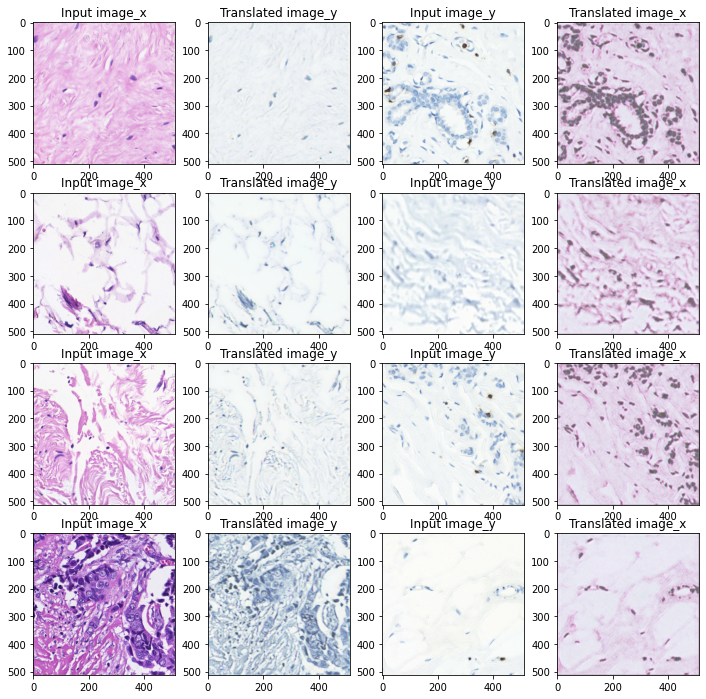

2750/2750 [==============================] - 5600s 2s/step - total_loss_G: -0.2068 - total_loss_F: 0.4636 - D_X_loss: 96.4424 - D_Y_loss: 128.6414 - generator_G_loss: -0.4218 - generator_F_loss: -0.4390 - identity_loss_G: 0.0663 - identity_loss_F: 0.2747 - cycle_loss_G: 0.1487 - cycle_loss_F: 0.6279
Epoch 2/20
2750/2750 [==============================] - ETA: 0s - total_loss_G: -0.3585 - total_loss_F: -0.1023 - D_X_loss: 0.8169 - D_Y_loss: 4.2663 - generator_G_loss: -0.3977 - generator_F_loss: -0.4404 - identity_loss_G: 0.0097 - identity_loss_F: 0.0999 - cycle_loss_G: 0.0295 - cycle_loss_F: 0.2382

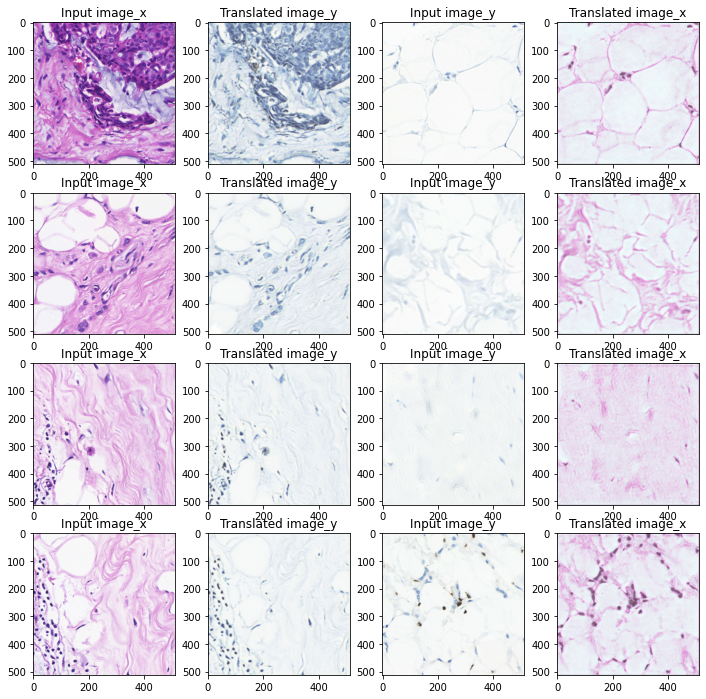

2750/2750 [==============================] - 5600s 2s/step - total_loss_G: -0.3585 - total_loss_F: -0.1024 - D_X_loss: 0.8172 - D_Y_loss: 4.2648 - generator_G_loss: -0.3977 - generator_F_loss: -0.4404 - identity_loss_G: 0.0097 - identity_loss_F: 0.0999 - cycle_loss_G: 0.0295 - cycle_loss_F: 0.2382
Epoch 3/20
2750/2750 [==============================] - ETA: 0s - total_loss_G: -0.3669 - total_loss_F: -0.1839 - D_X_loss: 0.3942 - D_Y_loss: 0.1213 - generator_G_loss: -0.3961 - generator_F_loss: -0.4403 - identity_loss_G: 0.0071 - identity_loss_F: 0.0754 - cycle_loss_G: 0.0221 - cycle_loss_F: 0.1810

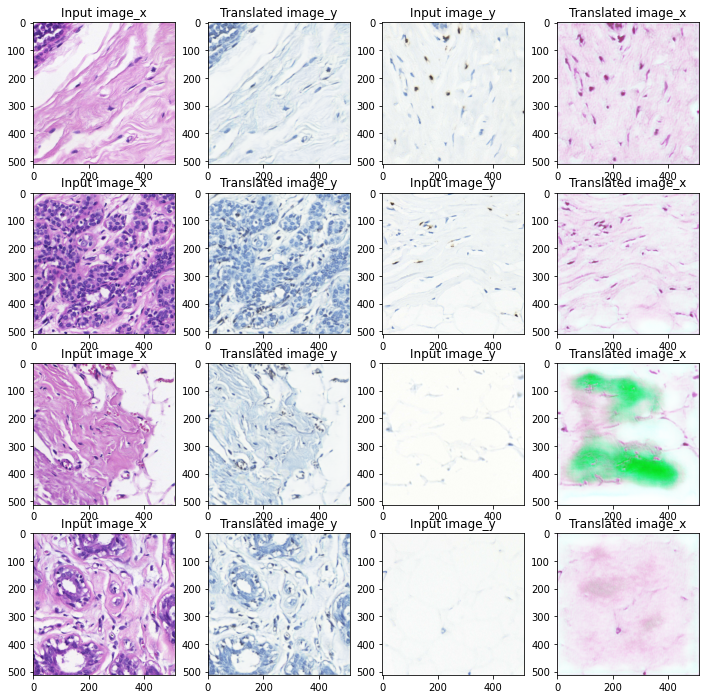

2750/2750 [==============================] - 5599s 2s/step - total_loss_G: -0.3669 - total_loss_F: -0.1839 - D_X_loss: 0.3942 - D_Y_loss: 0.1213 - generator_G_loss: -0.3961 - generator_F_loss: -0.4403 - identity_loss_G: 0.0071 - identity_loss_F: 0.0754 - cycle_loss_G: 0.0221 - cycle_loss_F: 0.1809
Epoch 4/20
2750/2750 [==============================] - ETA: 0s - total_loss_G: -0.3769 - total_loss_F: -0.1659 - D_X_loss: 0.4357 - D_Y_loss: 0.7164 - generator_G_loss: -0.4013 - generator_F_loss: -0.4366 - identity_loss_G: 0.0058 - identity_loss_F: 0.0802 - cycle_loss_G: 0.0185 - cycle_loss_F: 0.1904

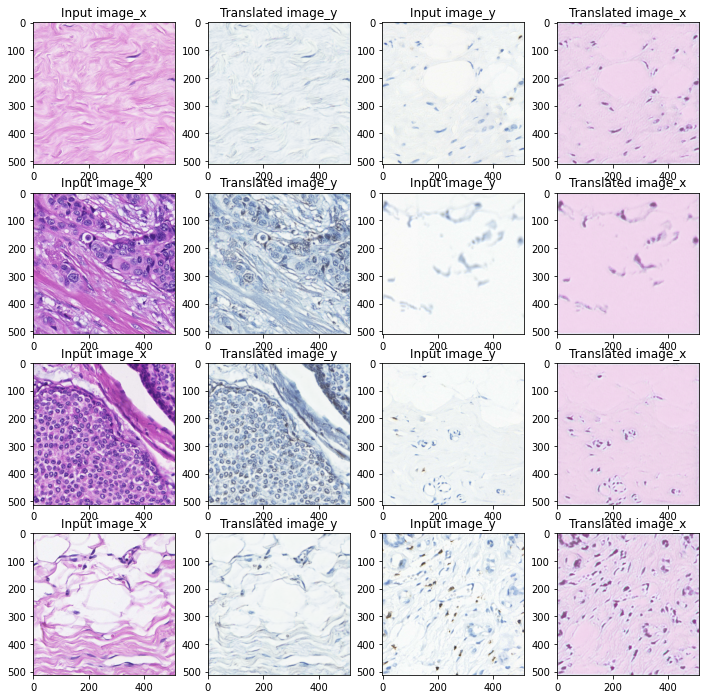

2750/2750 [==============================] - 5598s 2s/step - total_loss_G: -0.3769 - total_loss_F: -0.1658 - D_X_loss: 0.4357 - D_Y_loss: 0.7162 - generator_G_loss: -0.4013 - generator_F_loss: -0.4366 - identity_loss_G: 0.0058 - identity_loss_F: 0.0803 - cycle_loss_G: 0.0185 - cycle_loss_F: 0.1905
Epoch 5/20
2750/2750 [==============================] - ETA: 0s - total_loss_G: -0.3849 - total_loss_F: -0.2249 - D_X_loss: 0.4125 - D_Y_loss: 0.5622 - generator_G_loss: -0.4074 - generator_F_loss: -0.4338 - identity_loss_G: 0.0052 - identity_loss_F: 0.0573 - cycle_loss_G: 0.0173 - cycle_loss_F: 0.1516

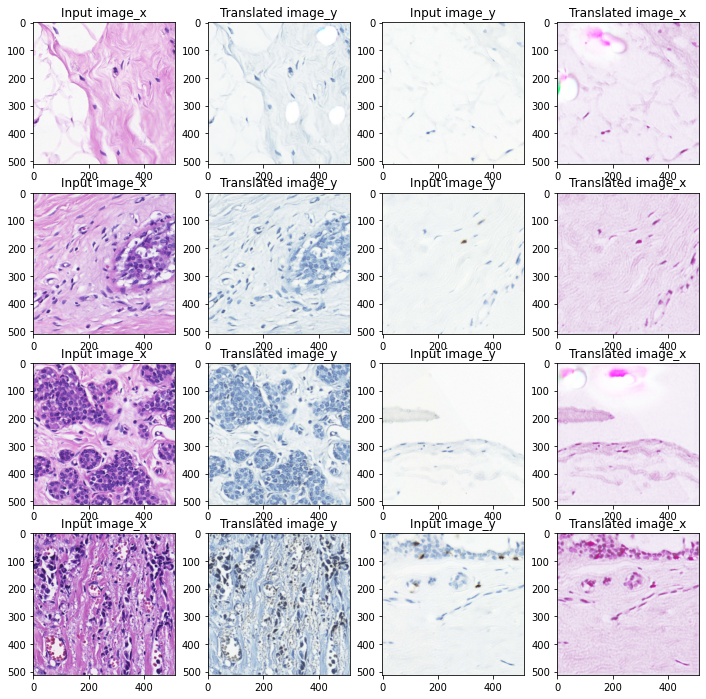

2750/2750 [==============================] - 5600s 2s/step - total_loss_G: -0.3849 - total_loss_F: -0.2249 - D_X_loss: 0.4124 - D_Y_loss: 0.5620 - generator_G_loss: -0.4074 - generator_F_loss: -0.4338 - identity_loss_G: 0.0052 - identity_loss_F: 0.0573 - cycle_loss_G: 0.0173 - cycle_loss_F: 0.1516
Epoch 6/20
2750/2750 [==============================] - ETA: 0s - total_loss_G: -0.3888 - total_loss_F: -0.2592 - D_X_loss: 0.3451 - D_Y_loss: 0.0774 - generator_G_loss: -0.4086 - generator_F_loss: -0.4356 - identity_loss_G: 0.0049 - identity_loss_F: 0.0429 - cycle_loss_G: 0.0149 - cycle_loss_F: 0.1335

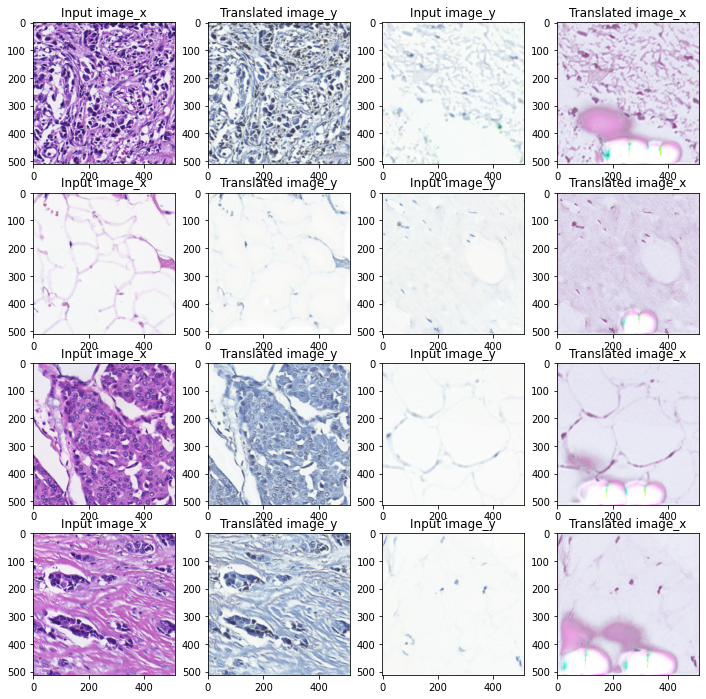

2750/2750 [==============================] - 5602s 2s/step - total_loss_G: -0.3888 - total_loss_F: -0.2591 - D_X_loss: 0.3451 - D_Y_loss: 0.0773 - generator_G_loss: -0.4086 - generator_F_loss: -0.4356 - identity_loss_G: 0.0049 - identity_loss_F: 0.0430 - cycle_loss_G: 0.0149 - cycle_loss_F: 0.1335
Epoch 7/20
 139/2750 [>.............................] - ETA: 1:27:32 - total_loss_G: -0.3858 - total_loss_F: -0.1814 - D_X_loss: 0.4605 - D_Y_loss: 0.0662 - generator_G_loss: -0.4094 - generator_F_loss: -0.4374 - identity_loss_G: 0.0059 - identity_loss_F: 0.0783 - cycle_loss_G: 0.0176 - cycle_loss_F: 0.1777

In [ ]:
cycle_gan_model.fit(
    train_data_loader,
    epochs=20,
    callbacks=[plotter, model_checkpoint_callback],
)

# inference

In [15]:
cycle_gan_model.generator_G.load_weights("./weights/cycle_gan/HE_IHC_dataset/(256, 256)/cyclegan_checkpoints.019/generator_G.hdf5")
cycle_gan_model.generator_F.load_weights("./weights/cycle_gan/HE_IHC_dataset/(256, 256)/cyclegan_checkpoints.019/generator_F.hdf5")
cycle_gan_model.discriminator_X.load_weights("./weights/cycle_gan/HE_IHC_dataset/(256, 256)/cyclegan_checkpoints.019/discriminator_X.hdf5")
cycle_gan_model.discriminator_Y.load_weights("./weights/cycle_gan/HE_IHC_dataset/(256, 256)/cyclegan_checkpoints.019/discriminator_Y.hdf5")

In [13]:
from src.data_loader.utils import imread  
import cv2

index = 45

image_array = imread(f'./datasets/cycle_gan/HE_IHC_dataset/HE/test\\CD3CD20CD79_0303_HE\\{index}.png', channel="rgb")
target_image_array = imread(f'./datasets/cycle_gan/HE_IHC_dataset/IHC/test\\CD3CD20CD79_0303_IHC\\{index}.png', channel="rgb")

target_predicted_image_array = cv2.resize(src=image_array, dsize=(256,256), interpolation=cv2.INTER_LINEAR)
target_predicted_image_array = np.expand_dims(target_predicted_image_array, axis=0)
target_predicted_image_array = (target_predicted_image_array / 127.5) - 1 
target_predicted_image_array = cycle_gan_model.generator_G.predict(target_predicted_image_array)[0]
target_predicted_image_array = (target_predicted_image_array + 1) * 127.5
target_predicted_image_array = target_predicted_image_array.astype("uint8")

predicted_image_array = cv2.resize(src=target_image_array, dsize=(256,256), interpolation=cv2.INTER_LINEAR)
predicted_image_array = np.expand_dims(predicted_image_array, axis=0)
predicted_image_array = (predicted_image_array / 127.5) - 1 
predicted_image_array = cycle_gan_model.generator_F.predict(predicted_image_array)[0]
predicted_image_array = (predicted_image_array + 1) * 127.5
predicted_image_array = predicted_image_array.astype("uint8")


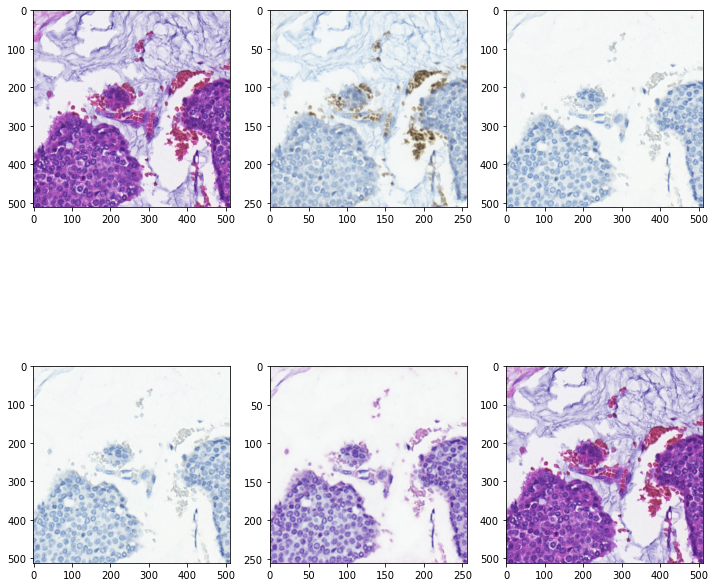

In [14]:
_, ax = plt.subplots(2, 3, figsize=(12, 12))
ax[0, 0].imshow(image_array)
ax[0, 1].imshow(target_predicted_image_array)
ax[0, 2].imshow(target_image_array)
ax[1, 0].imshow(target_image_array)
ax[1, 1].imshow(predicted_image_array)
ax[1, 2].imshow(image_array)

# Unused Code

In [23]:
image_array, target_image_array = train_data_loader[0]

In [24]:
source_array = image_array[0]
source_array = (source_array + 1) * 127.5
source_array = source_array.astype("uint8")

In [25]:
converted = generator_G(image_array)[0]
converted = np.array(converted)
converted = (converted + 1) * 127.5
converted = converted.astype("uint8")

In [26]:
temp_array = image_array[0]
temp_array = (temp_array + 1) * 127.5
temp_array = temp_array.astype("uint8")

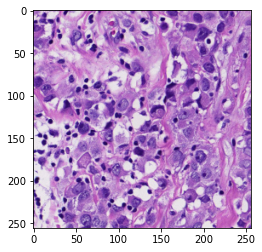

In [28]:
from matplotlib import pyplot as plt

plt.imshow(source_array)

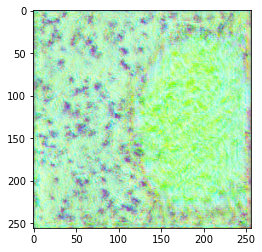

In [29]:
from matplotlib import pyplot as plt

plt.imshow(converted)

# Unused Code

In [ ]:
y_true = train_data_loader[0][0]
y_true = tf.convert_to_tensor(y_true)
one_array = np.ones((1,512,512,3))
one_diff_array = deepcopy(one_array)
one_diff_array[:,:,:,0] = 0
one_diff_array[:,:30,:30,1] = 0

one_array = tf.convert_to_tensor(one_array)
one_diff_array = tf.convert_to_tensor(one_diff_array)

In [ ]:
beta = 0.7
CHANNEL_WEIGHTED_AXIS = [1, 2]
y_true = one_array
y_pred = one_diff_array
smooth = K.epsilon()

alpha = 1 - beta
prevalence_per_channel = \
    K.mean((y_true + 1) / 2, axis=CHANNEL_WEIGHTED_AXIS)

tp = K.sum(y_true * y_pred, axis=CHANNEL_WEIGHTED_AXIS)
tn = K.sum((1 - y_true) * (1 - y_pred), axis=CHANNEL_WEIGHTED_AXIS)
fp = K.sum(y_pred, axis=CHANNEL_WEIGHTED_AXIS) - tp
fn = K.sum(y_true, axis=CHANNEL_WEIGHTED_AXIS) - tp

channel_weighted_dice_loss = \
    (tp + smooth) / (tp + alpha * fn + beta * fp + smooth) * \
    (smooth + prevalence_per_channel)

print(f"channel_weighted_dice: {channel_weighted_dice_loss}")
print(f"channel_weighted_dice_loss: {channel_weighted_dice_loss.shape}")

channel_weighted_dice_loss = K.mean(channel_weighted_dice_loss)

print(f"prevalence_per_channel_shape: {prevalence_per_channel.shape}")
print(f"true_positive_shape: {tp.shape}")
print(f"false_positive_shape: {tp.shape}")
print(f"false_negative_shape: {tn.shape}")
print(f"channel_weighted_dice: {channel_weighted_dice_loss}")


In [ ]:
from tensorflow.keras import backend as K

beta=0.7
CHANNEL_WEIGHTED_AXIS=[1,2]
smooth=K.epsilon()

alpha = 1 - beta

y_true = tf.constant(image_array)
y_pred = tf.constant(image_array)

y_true = (y_true + 1 + smooth) / 2
y_pred = (y_pred + 1 + smooth) / 2

prevalence_per_channel = K.mean(y_true, axis=CHANNEL_WEIGHTED_AXIS)

weight_per_channel = 1 / prevalence_per_channel
weight_per_channel_sum = K.sum(weight_per_channel, axis=-1)
weight_per_channel_sum = tf.expand_dims(weight_per_channel_sum, axis=-1)
weight_per_channel = weight_per_channel / weight_per_channel_sum

tp = K.sum(y_true * y_pred, axis=CHANNEL_WEIGHTED_AXIS)
fp = K.sum(y_pred, axis=CHANNEL_WEIGHTED_AXIS) - tp
fn = K.sum(y_true, axis=CHANNEL_WEIGHTED_AXIS) - tp

channel_weighted_dice_loss = (tp + smooth) / (tp + alpha * fn + beta * fp + smooth) * \
    (smooth + weight_per_channel)

print(channel_weighted_dice_loss)

channel_weighted_dice_loss = K.mean(channel_weighted_dice_loss)